In [48]:
import sys
sys.path.append('/libs')
sys.path.append('/datas')
from Balancer_lib_new import *
from Datas_4_new import *
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import random
import copy
import numpy as np
import pandas as pd
import pprint as pp
import copy
import pprint as pp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
from datetime import datetime


Description of Strategies

Strategy 1 - DAO decided to change ratio of Tokens to ratio1 on step X . We computer using historical price dates the losses of pool and new composition of Tokens for every Start step X.

Strategy 2 - DAO decided to change ratio of Tokens to ratio1 on step X and we need to come to new composition of Tokens continuously for 100 steps, and start this procedure on Start step X.

Strategy 3 - DAO decided to change ratio of Tokens to ratio1 on step X and we need to come to new composition of Tokens with minimum losses using the movement of market prices.

In [49]:
#init pools for Three Strategies
n=4# the number of Tokens in Pool - do not change this parametr

# you may change parametrs below
fee=0.03
amount=1000000#amount of each token in pool
step=0
ratio=[0.25]*n
pool1 = pool_from_ratio_value(ratio, datas, step, amount*4, n)
weights1=[0.25]*n

ratio1=[0.35, 0.30, 0.2,0.15]# new ratio

In [50]:
#prepare dates for charts for Strategy 1
st=[]
prices=[]
arr_pool1=[]
arr_value_pool1=[]
arr_value_tokens1=[]
arr_IL1=[]
w1=[]
arr_ratio1=[]

#Strategy1 - datas
for step in range(0, len(datas)):
    st.append(step)
    prices.append(datas[step][0:n])
    pool11 = pool_from_ratio_oldpool(pool1, ratio1, datas, step,  n)
    weights11 = weights_from_new_pool(pool11, datas, step, n)
    w1.append(weights11)
    
    value01=value(pool1, datas, step, n)#before swap
    sw1 = swaps_new1(pool1, weights11, datas, step, n, value01, fee)
    pool11 =sw1[0]
    arr_pool1.append(pool11)
    v1=value_tokens(pool11, datas, step, n)
    arr_value_tokens1.append(v1)
    rt11=ratio_tokens(pool11, datas, step, n)
    arr_ratio1.append(rt11)
    value1=value(pool11, datas, step, n)#after swap
    
    arr_value_pool1.append(value1)
    IL1=(value1-value01)/value01
    arr_IL1.append(IL1)
    

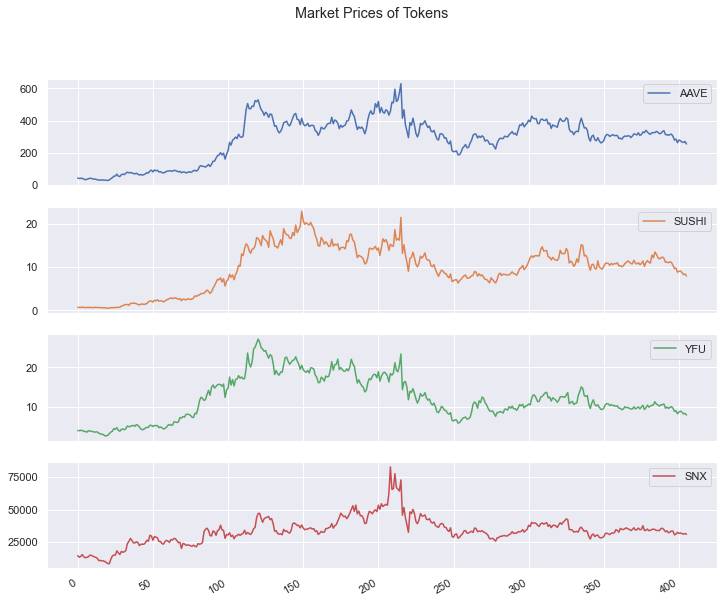

In [51]:
#Market Prices. Period - 400 days

df=pd.DataFrame(prices, columns=['AAVE', 'SUSHI', 'YFU', 'SNX'])
axs = df.plot(figsize=(12, 10), subplots=True, title='Market Prices of Tokens')

<AxesSubplot:title={'center':'Ratio of Value of Tokens'}>

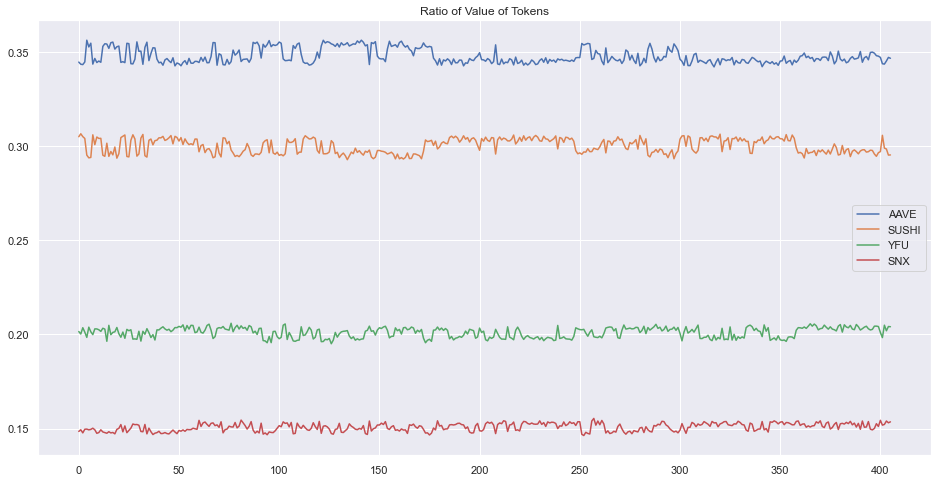

In [52]:
df=pd.DataFrame(arr_ratio1, columns=['AAVE', 'SUSHI', 'YFU', 'SNX'])
df.plot( figsize=(16, 8), title='Ratio of Value of Tokens')

<AxesSubplot:title={'center':'IL of the pool after Swaps for any Step'}>

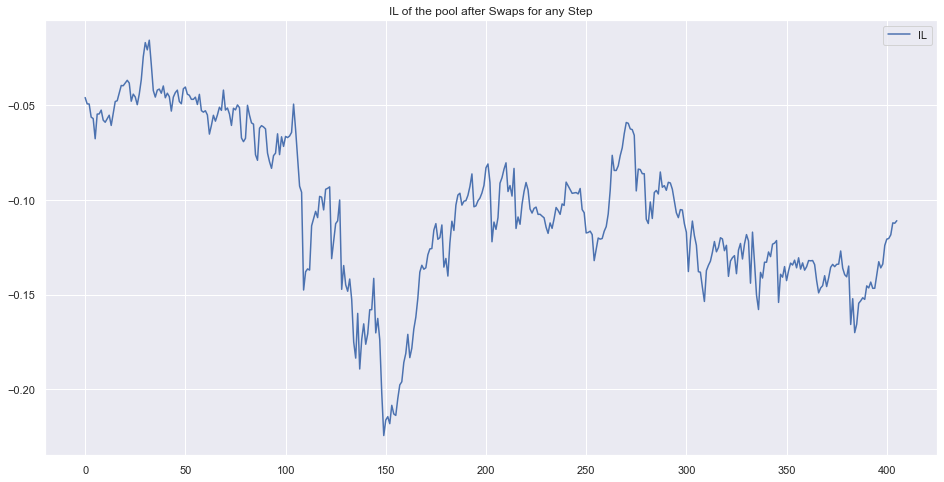

In [53]:
#IL of the pool after Swaps for any Step
df=pd.DataFrame(arr_IL1, columns=['IL'])
df.plot( figsize=(16, 8), title='IL of the pool after Swaps for any Step')

In [54]:
#prepare dates for charts Strategy 2 - changing weights during 100 steps
pool2 = pool_from_ratio_value(ratio, datas, 0, amount*4, n)
weights2=[0.25]*n
ratio1=[0.35,0.3,0.2,0.15]

start_step = 100
end_step = 200
pool2_end = pool_from_ratio_oldpool(pool2, ratio1, datas, start_step,  n)
weights_end = weights_from_new_pool(pool2_end, datas, start_step, n)
dif_weights = [0]*n
for i in range(0,n):
    dif_weights[i] = (weights_end[i] - weights2[i])/(end_step - start_step)

st2=[]
arr_pool2=[]
arr_value_tokens2=[]
arr_value_pool2=[]
arr_IL2=[]
w2=[]
arr_ratio2=[]
arr_tot_IL2=[]
IL2_tot=0
for step in range(start_step, end_step+20):
    st2.append(step)
    value02=value(pool2, datas, step, n)#before swap
    if start_step<=step and step<=end_step:
        for i in range(0, n):
            weights2[i]+=dif_weights[i]
         
        sw2 = swaps_new1(pool2, weights2, datas, step, n, value02, fee)
        pool2 =sw2[0]
    
    w2.append(weights2)
    arr_pool2.append(pool2)
    v2=value_tokens(pool2, datas, step, n)
    arr_value_tokens2.append(v2)
    rt2=ratio_tokens(pool2, datas, step, n)
    arr_ratio2.append(rt2)
    value2=value(pool2, datas, step, n)#after swap
    
    arr_value_pool2.append(value2)
    IL2=(value2-value02)/value02
    arr_IL2.append(IL2)
    IL2_tot+=IL2
    arr_tot_IL2.append(IL2_tot)
    

<AxesSubplot:title={'center':'Strategy 2 - Ratio of Value of Tokens'}>

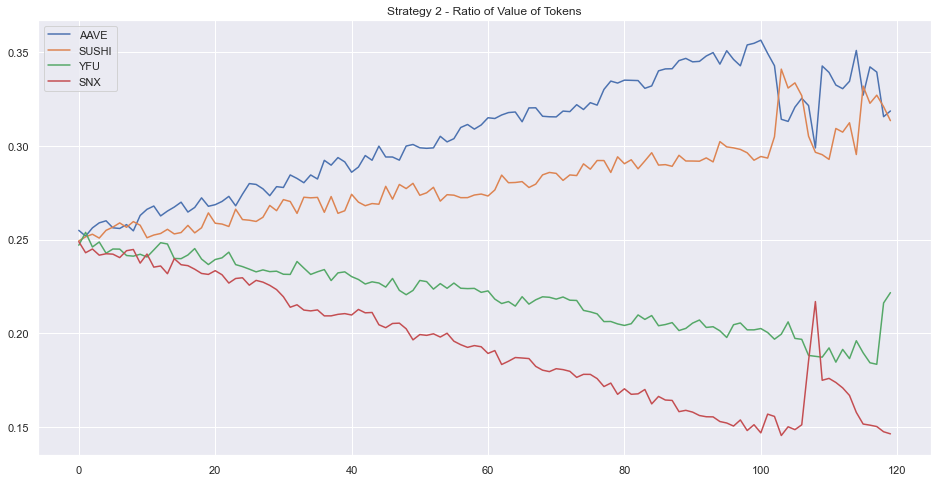

In [55]:
df=pd.DataFrame(arr_ratio2, columns=['AAVE', 'SUSHI', 'YFU', 'SNX'])
df.plot( figsize=(16, 8), title='Strategy 2 - Ratio of Value of Tokens')

In [56]:
#Strategy 2 - IL
fig = make_subplots(subplot_titles=('' ), specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=st2, y=arr_tot_IL2, line=dict(color='red'), name='Total IL2'), secondary_y=False)

fig.update_layout(title_text='<b>Strategy 2 - Total (Summary) IL  of Pool </b>')
fig.update_xaxes(title_text='Step')

fig.show()

In [57]:
#Strategy 2 - IL per Steps

fig = make_subplots(subplot_titles=('' ), specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=st2, y=arr_IL2, line=dict(color='red'), name='IL2'), secondary_y=False)

fig.update_layout(title_text='<b>Strategy 2 - IL per step</b>')
fig.update_xaxes(title_text='Step')
fig.update_layout(yaxis_range=[-0.15,0.005])

fig.show()

In [63]:
##prepare dates for charts Strategy 3 - when the prices have come 
pool3 = pool_from_ratio_value(ratio, datas, 0, amount*4, n)
weights3=[0.25]*n
ratio1=[0.35,0.3,0.2,0.15]

start_step = 0
end_step = len(datas)
#pool3_end = pool_from_ratio_oldpool(pool3, ratio1, datas, start_step,  n)
#weights_end3 = weights_from_new_pool(pool3_end, datas, start_step, n)

#dif_weights_tot = [0]*n
#for i in range(0,n):
#    dif_weights_tot[i] = (weights_end3[i] - weights3[i])

#value0=value(pool1, datas, 0, n)
st3=[]
arr_pool3=[]
arr_value_tokens3=[]
arr_value_pool3=[]
arr_IL3=[]
w3=[]
arr_ratio3=[]
arr_tot_IL3=[]
IL3_tot=0
#print(pool3)
for step in range(0, len(datas)):

    st3.append(step)
    value03=value(pool3, datas, step, n)#before swap
    delta_price = delta_spot_market_procent(pool3, weights3, datas, step, n, value03)
    
    if start_step<=step and step<=end_step:
        current_ratio = ratio_tokens(pool3, datas, step, n)
        
        if ratio1[0]>current_ratio[0] and ratio1[n-1]<current_ratio[n-1] and delta_price[0]>0 and delta_price[1]>0:
            pool3_end = pool_from_ratio_oldpool(pool3, ratio1, datas, step,  n)
            w3=weights_from_new_pool(pool3_end, datas, step, n)
            for i in range(0, n):
                weights3[i]+=(w3[i]-weights3[i])/10
         
        sw3 = swaps_new1(pool3, weights3, datas, step, n, value03, fee)
        pool3 =sw3[0]

    w3.append(weights3)

    arr_pool3.append(pool3)
    v3=value_tokens(pool3, datas, step, n)
    arr_value_tokens3.append(v3)
    rt3=ratio_tokens(pool3, datas, step, n)
    arr_ratio3.append(rt3)

    value3=value(pool3, datas, step, n)#after swap

    arr_value_pool3.append(value3)
    IL3=(value3-value03)/value03
    arr_IL3.append(IL3)
    IL3_tot+=IL3
    arr_tot_IL3.append(IL3_tot)


<AxesSubplot:title={'center':'Strategy 3 - Ratio of Value of Tokens'}>

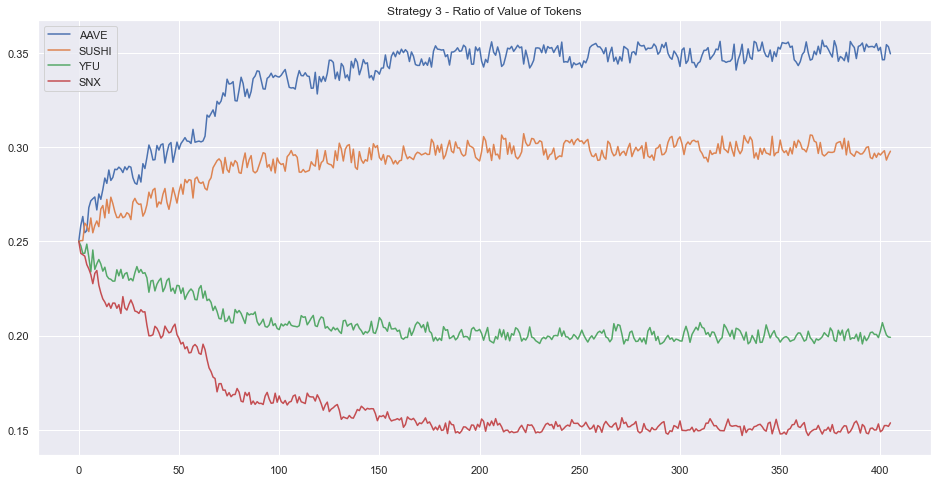

In [64]:
df=pd.DataFrame(arr_ratio3,  columns=['AAVE', 'SUSHI', 'YFU', 'SNX'])
df.plot( figsize=(16, 8), title='Strategy 3 - Ratio of Value of Tokens')

<AxesSubplot:title={'center':'Strategy 3  - IL of pool'}>

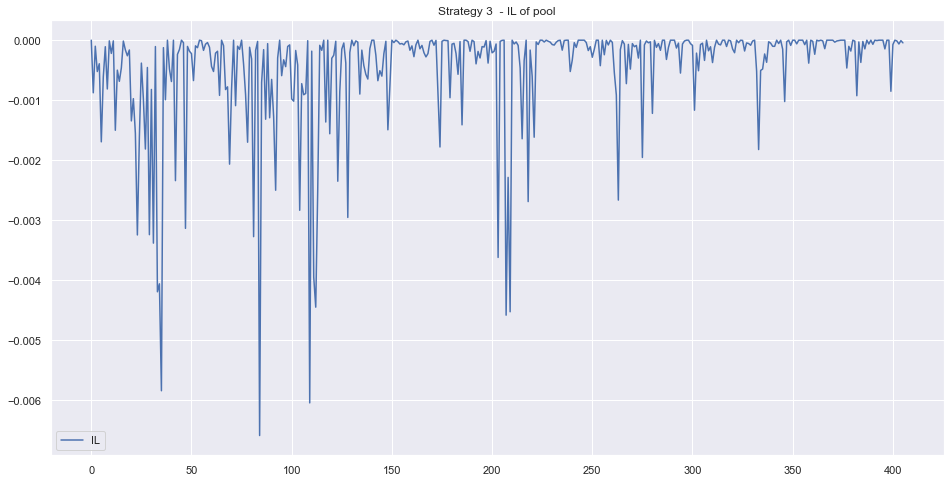

In [65]:
#IL
df=pd.DataFrame(arr_IL3, columns=['IL'])
df.plot( figsize=(16, 8), title='Strategy 3  - IL of pool')

In [66]:
fig = make_subplots(subplot_titles=('' ), specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=st3, y=arr_tot_IL3, line=dict(color='red'), name='Total IL3'), secondary_y=False)

fig.update_layout(title_text='<b>Strategy 3 - Total (Summary) IL  of Pool </b>')
fig.update_xaxes(title_text='Step')
fig.update_layout(yaxis_range=[-0.5,0.001])

fig.show()

In [67]:
fig = make_subplots(subplot_titles=('' ), specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=st3, y=arr_IL1, mode='markers', line=dict(color='blue'), name='Total IL1 in each Step'), secondary_y=False)
fig.add_trace(go.Scatter(x=st2, y=arr_tot_IL2, mode='markers', line=dict(color='green'), name='Total IL2'), secondary_y=False)
fig.add_trace(go.Scatter(x=st3, y=arr_tot_IL3, mode='markers', line=dict(color='brown'), name='Total IL3'), secondary_y=False)

fig.update_layout(title_text='<b>Compare Strategies - Total (Summary) IL  of Pool </b>')
fig.update_xaxes(title_text='Step')
fig.update_layout(yaxis_range=[-0.25,0.005])

fig.show()